## Predicting Heart Hate in GPS Attendance System using LSTM Model.

### Training an LSTM model to predict heart rate in n seconds in future based on the sensor measurements over the past 60 seconds

In [50]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# location of the fit files
fit_path = "/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv"
fit_test_path = "/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv"
graph_path = "/home/u718bf860481d17b6c347f8563d2ae4e/GPS/graphs"
os.chdir(fit_path)


In [51]:
# add calculated altitude difference column, and 5sec moving average column. Remove geographical coordinates for privacy.
fit_files = glob.glob("*.csv")
for file in fit_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')
    df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df = df.drop(['position_lat','position_long'], axis=1, errors='ignore')
    df.to_csv(fit_path+'/'+file)


In [52]:
import pandas as pd

# Define the file path
csv_file_path = "/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-07-16-10-15-34.fit.csv"

# Define the columns you want to display
columns_to_display = ["heart_rate", "enhanced_speed", "rolling_ave_alt", "cadence", "distance", "enhanced_altitude"]

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first 5 rows of the specified columns
print(df[columns_to_display].head(5))


   heart_rate  enhanced_speed  rolling_ave_alt  cadence  distance  \
0          70             0.0              0.4        0      0.65   
1          70             0.0              0.4        0      1.14   
2          70             0.0              0.4        0      2.28   
3          70             0.0              0.4        0      3.99   
4          71             0.0              0.4        0      6.52   

   enhanced_altitude  
0              275.2  
1              275.2  
2              275.2  
3              275.2  
4              275.4  


In [53]:
# set parameters, file names
#select the features for EDA graphs:
eda_model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt", "cadence", "distance", "enhanced_altitude"] #  cadence, enhanced_altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt
#select the predictors for the model:
model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt","cadence"] #  cadence, altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt
batch_size = 250 # trau718bf860481d17b6c347f8563d2ae4e/GPS/ining batch size for the LSTM
epochs = 50 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.001
decay_rate = 0.001
n_X = 120 # number of timesteps for training
n_y = 22 # number of timesteps in future for prediction
step = 1 # step size of predictors for model training
sequence_length = int(n_X/step)
n_fit_files_test_set = 10 # number of files for validation dataset (only 1 validation file supported at the moment)
# select the training files and the validation files 
train_files = glob.glob(fit_path+"/*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob(fit_path+"/*.csv")[-n_fit_files_test_set:]
test_files = glob.glob(fit_test_path+"/*.csv")


In [54]:
# calculate the data normalisation parameters from all training data
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std
li = []
for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df_mean, df_std = normalize(df)
def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## Short EDA
### Selected features are shown on the plots.

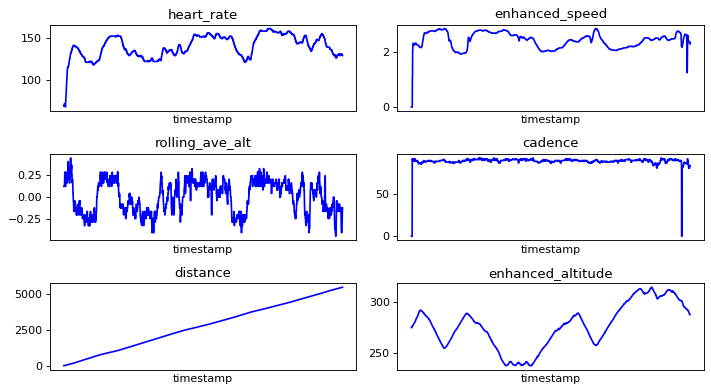

In [55]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[eda_model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=int(len(eda_model_features)/2+0.5), ncols=2, figsize=(9, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(eda_model_features)):
        key = eda_model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)
plt.savefig(graph_path+"/HR_eda.png")


## Create validation dataset

In [56]:
# validation dataset - train each file at the time
n=0
for file in valid_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    if n==0 : dataset_val_old = dataset_val
    if n>0 : dataset_val_old = dataset_val.concatenate(dataset_val_old)
    
    n=n+1

dataset_val = dataset_val_old

## calculate stats for a naive model

In [57]:
# Calculate statistics for the naive model
# make dataframe for the naive model
d_naive = pd.DataFrame(columns=['measured', 'predicted'])
d_naive['measured']=denormalize_hr(x[n_y:,0])
d_naive['predicted']=denormalize_hr(x[:-n_y,0])
# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy
y_test, pred_test = d_naive['measured'].values, d_naive['predicted'].values
MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)
test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h
mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))
print('Naive model\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))

Naive model
MAE = 2.688, MSE = 17.328
Mean and 95% prediction interval = -0.46310962901208835 +/- 8.108337753350181
Uncertainty of mean = 0.16566032924009738


/tmp/ipykernel_850233/3221573495.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return data*df_std[0]+df_mean[0]


## Build the model

In [58]:
#Load the TensorBoard notebook extension
%load_ext tensorboard
# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch
# the model architecture
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
outputs = keras.layers.LSTM(4, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(outputs)
model = keras.Model(inputs=inputs, outputs=outputs)
# learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=50000,
    decay_rate=0.001)
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_mae", min_delta=0, patience=5, verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/', histogram_freq=1)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_mae",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["mae"], loss="mae")
model.summary()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 4)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 4)                 144       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 149 (596.00 Byte)
Trainable params: 149 (596.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Load the training data, train the model

### Each file is processed separately for creating the training dataset, as every file is disconnected from previous file and the moving window cannot be extendented over.

In [59]:
# training dataset
n=0
for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size
    )
    if n==0 : dataset_train_old = dataset_train
    if n>0 : dataset_train_old = dataset_train.concatenate(dataset_train_old)
    n=n+1
dataset_train=dataset_train_old
len(dataset_train)

/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-07-16-10-15-34.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-05-02-08-59-37.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-05-09-10-51-15.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-03-28-08-52-59.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-07-25-08-07-59.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-05-12-08-15-45.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-05-31-11-04-24.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-07-03-14-10-28.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-03-25-10-40-55.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-08-10-12-54-01.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_csv/RUN_2021-04-16-09-04-35.fit.csv
/home/u718bf860481d17b6c347f8563

464

In [60]:
# train the model, with tensorboard visualisations
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback, tensorboard_callback],
    verbose=1
)

Epoch 1/50
461/464 [============================>.] - ETA: 0s - loss: 0.3295 - mae: 0.3295
Epoch 1: val_mae improved from inf to 0.26768, saving model to model_checkpoint.h5
464/464 [==============================] - 10s 19ms/step - loss: 0.3316 - mae: 0.3316 - val_loss: 0.2677 - val_mae: 0.2677
Epoch 2/50
462/464 [============================>.] - ETA: 0s - loss: 0.2169 - mae: 0.2169
Epoch 2: val_mae improved from 0.26768 to 0.25980, saving model to model_checkpoint.h5
464/464 [==============================] - 8s 18ms/step - loss: 0.2200 - mae: 0.2200 - val_loss: 0.2598 - val_mae: 0.2598
Epoch 3/50
463/464 [============================>.] - ETA: 0s - loss: 0.2093 - mae: 0.2093
Epoch 3: val_mae improved from 0.25980 to 0.25609, saving model to model_checkpoint.h5
464/464 [==============================] - 8s 18ms/step - loss: 0.2105 - mae: 0.2105 - val_loss: 0.2561 - val_mae: 0.2561
Epoch 4/50
462/464 [============================>.] - ETA: 0s - loss: 0.2061 - mae: 0.2061
Epoch 4: val

In [61]:
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

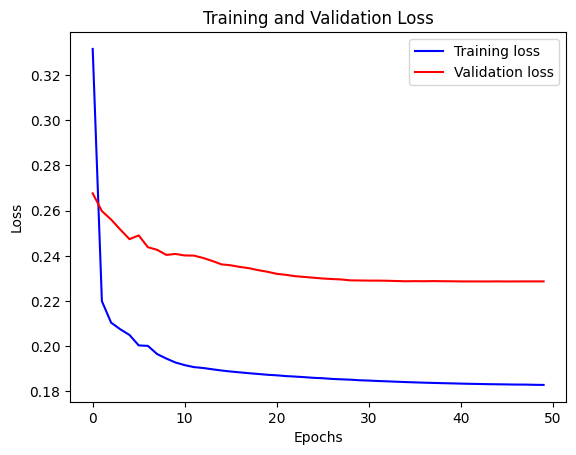

In [62]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
visualize_loss(history, "Training and Validation Loss")
plt.savefig(graph_path+'/HR_his_t'+str(n_y)+".png")


## Check the model predictions visually

In [63]:
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=10
    )
    if n>0:
        dataset_test_old = dataset_train_old.concatenate(dataset_test)
    dataset_test_old = dataset_test
    n=n+1
dataset_test = dataset_test_old

/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv/RUN_2021-08-05-11-12-41.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv/RUN_2021-08-29-09-28-52.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv/RUN_2021-09-01-09-09-44.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv/RUN_2021-08-28-10-18-42.fit.csv
/home/u718bf860481d17b6c347f8563d2ae4e/GPS/fit_file_test_csv/RUN_2021-08-31-10-10-56.fit.csv


/tmp/ipykernel_850233/3221573495.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return data*df_std[0]+df_mean[0]


1/1 [==============================] - 0s 242ms/step


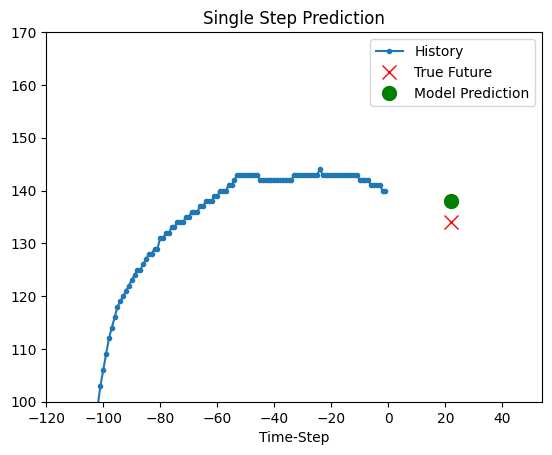

1/1 [==============================] - 0s 22ms/step


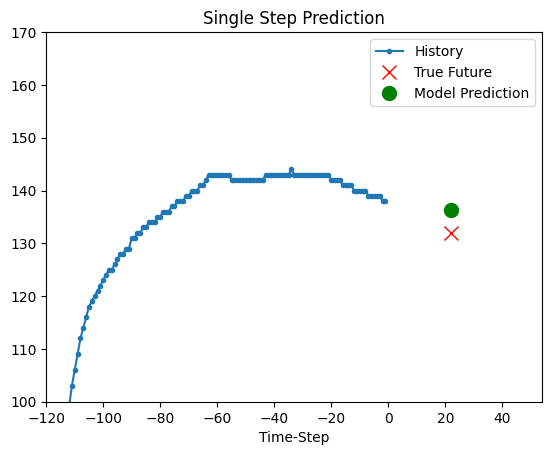

1/1 [==============================] - 0s 22ms/step


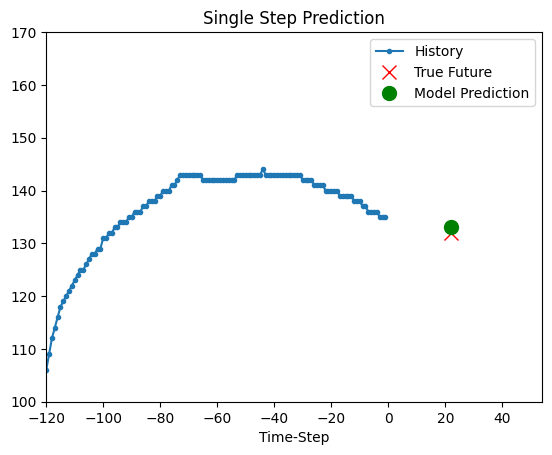

1/1 [==============================] - 0s 22ms/step


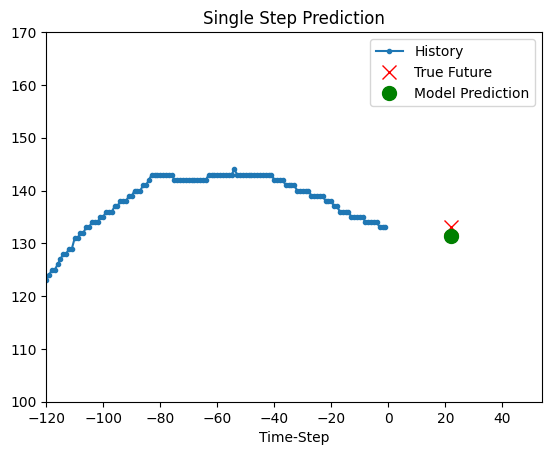

1/1 [==============================] - 0s 21ms/step


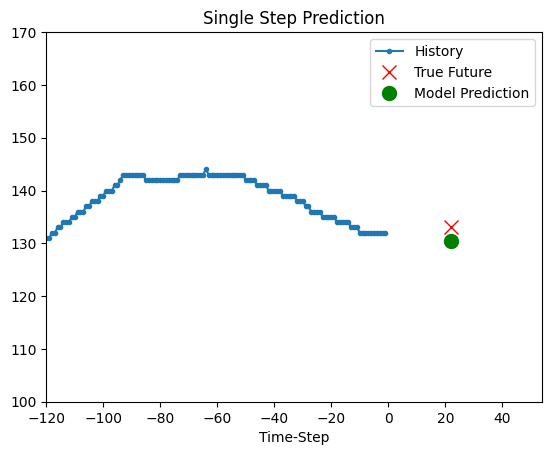

In [64]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return
for x, y in dataset_test.take(5):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        n_y,
        "Single Step Prediction",
    )

In [ ]:
# create a testing dataset from the kept-aside files
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=1
    )
    
    if n==0 : dataset_test_old = dataset_test
    if n>0 : dataset_test_old = dataset_test_old.concatenate(dataset_test)
    
    n=n+1
dataset_test = dataset_test_old

# make a dataframe with predictions and observations
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr( model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']
d = d.bfill()

## Result

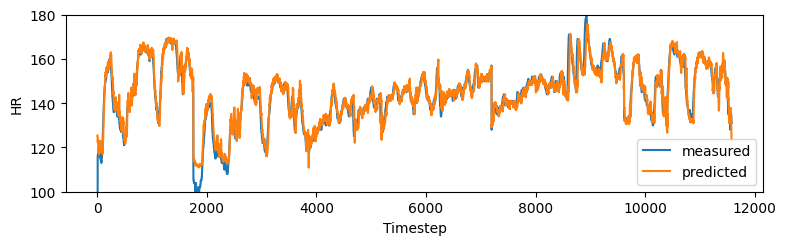

In [75]:
# time domain plot with observed blue, and predicted orange. Predicted values are calculated values where the previous 30 seconds of inputs are missing.
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(9, 2.3)
d.plot(ylim=(100,180), xlabel='Timestep', ylabel='HR', ax=ax1)
plt.savefig(graph_path+'/HR_ex_t'+str(n_y)+".png")

## Without one-API

In [95]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy
import numpy as np
# Load the actual and predicted values for the test dataset
y_test, pred_test = d['measured'].values, d['predicted'].values
# Calculate MSE and MAE for the test dataset
MSE_test = round(mean_squared_error(y_test, pred_test, squared=True), 3)
MAE_test = round(mean_absolute_error(y_test, pred_test), 3)
# Calculate the standard deviation of the difference and the mean of the difference
test_sdev = np.std(pred_test - y_test) * 1.96
test_mean = np.mean(pred_test - y_test)
# Calculate the mean and a 95% confidence interval for the difference
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se*scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h, h
mean_s,ci95_l,ci95_h,mean_uncertainty = mean_confidence_interval(data=(pred_test - y_test))
# Print the results
print('Test dataset\nMAE = ' + str(MAE_test) + ", MSE = " + str(MSE_test))
print('Mean and 95% prediction interval = {} +/- {}'.format(test_mean, test_sdev))
print('Uncertainty of mean = ' + str(mean_uncertainty))

Test dataset
MAE = 2.477, MSE = 15.169
Mean and 95% prediction interval = 0.4474712668912766 +/- 7.583193062717473
Uncertainty of mean = 0.0704719832106477


## With one-API

In [96]:
# Import necessary libraries, including the Intel(R) Extension for Scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearnex import patch_sklearn
import scipy
import numpy as np

# Enable Intel(R) Extension for Scikit-learn
patch_sklearn()

# Load the actual and predicted values for the test dataset
y_test, pred_test = d['measured'].values, d['predicted'].values

# Calculate MSE and MAE for the test dataset
MSE_test = round(mean_squared_error(y_test, pred_test, squared=True), 3)
MAE_test = round(mean_absolute_error(y_test, pred_test), 3)

# Calculate the standard deviation of the difference and the mean of the difference
test_sdev = np.std(pred_test - y_test) * 1.96
test_mean = np.mean(pred_test - y_test)

# Calculate the mean and a 95% confidence interval for the difference
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test - y_test))

# Print the results
print('Test dataset\nMAE = ' + str(MAE_test) + ", MSE = " + str(MSE_test))
print('Mean and 95% prediction interval = {} +/- {}'.format(test_mean, test_sdev))
print('Uncertainty of mean = ' + str(mean_uncertainty))

Test dataset
MAE = 2.477, MSE = 15.169
Mean and 95% prediction interval = 0.4474712668912766 +/- 7.583193062717473
Uncertainty of mean = 0.0704719832106477


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Performance Graph

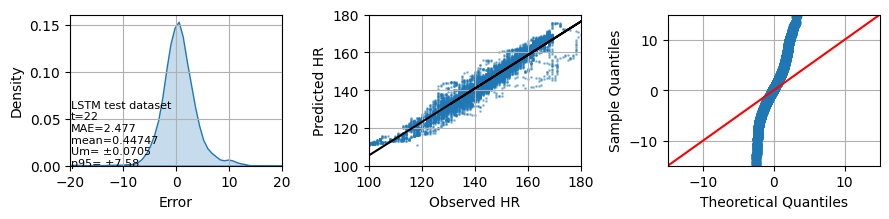

In [97]:
# graph the model performance
import seaborn as sns
import statsmodels.api as sm
m, b = np.polyfit(y_test, pred_test, 1)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(9, 2.3)
sns.kdeplot( x=pred_test-y_test, fill=True, ax=ax1, common_norm=False)
ax2.scatter(x=y_test, y=pred_test, s=1, alpha=0.4)
ax2.plot(y_test, m*y_test + b, c='black')
sm.qqplot((pred_test-y_test), line ='45', ax=ax3)
ax1.set_xlim(-20,20)
ax1.set_xlabel('Error')
ax2.set_xlabel('Observed HR')
ax2.set_ylabel('Predicted HR')
ax2.set_xlim(100,180)
ax2.set_ylim(100,180)
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax1.text(-19.8,0.0,'LSTM test dataset\nt='+ str(n_y) + '\nMAE='+str(MAE_test) + "\nmean="+ str(round(mean_s,5)) + "\nUm= ±"+ str(round(mean_uncertainty,4))+'\np95= ±'+ str(round(test_sdev,2)) , fontsize=8 )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_t'+str(n_y)+'-'+str(n_X) +".png")

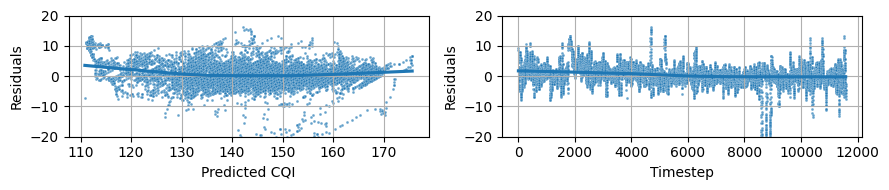

In [98]:
# further residuals plots
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(9, 2)
y_pred_error = (pred_test - y_test)
x_n = np.arange(0,len(y_pred_error))
sns.regplot(x=pred_test, y=y_pred_error, scatter=False,  ax=ax1, ci=95, lowess=True)
sns.regplot(x=x_n, y=y_pred_error, scatter=False,  ax=ax2, ci=95, lowess=True)
sns.scatterplot(x=pred_test, y=y_pred_error,  ax=ax1, alpha = 0.7, s=4)
sns.scatterplot(x=x_n, y=y_pred_error,  ax=ax2, alpha = 0.7, s=4)
ax2.set_ylim(-20,20)
ax1.set_ylim(-20,20)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Residuals')
ax1.set_xlabel('Predicted CQI')
ax1.set_ylabel('Residuals')
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_res_t'+str(n_y)+".png")

In [99]:

import timeit

# Define the code block you want to benchmark (with oneAPI)
def benchmark_with_oneapi():
    # Your existing code here
    y_test, pred_test = d['measured'].values, d['predicted'].values
    MSE_test = round(mean_squared_error(y_test, pred_test, squared=True), 3)
    MAE_test = round(mean_absolute_error(y_test, pred_test), 3)
    test_sdev = np.std(pred_test - y_test) * 1.96
    test_mean = np.mean(pred_test - y_test)
    mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test - y_test))# Define the code block you want to benchmark (without oneAPI)
def benchmark_without_oneapi():
    # Your existing code here
    y_test, pred_test = d['measured'].values, d['predicted'].values
    MSE_test = round(mean_squared_error(y_test, pred_test, squared=True), 3)
    MAE_test = round(mean_absolute_error(y_test, pred_test), 3)
    test_sdev = np.std(pred_test - y_test) * 1.96
    test_mean = np.mean(pred_test - y_test)
    mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test - y_test))

# Benchmark the code with oneAPI
execution_time_with_oneapi = timeit.timeit(benchmark_with_oneapi, number=100)

# Benchmark the code without oneAPI
execution_time_without_oneapi = timeit.timeit(benchmark_without_oneapi, number=100)


## Benchmark

Benchmark with oneAPI Execution Time: 0.07006612000986934 seconds
Benchmark without oneAPI Execution Time: 0.06880725384689867 seconds


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


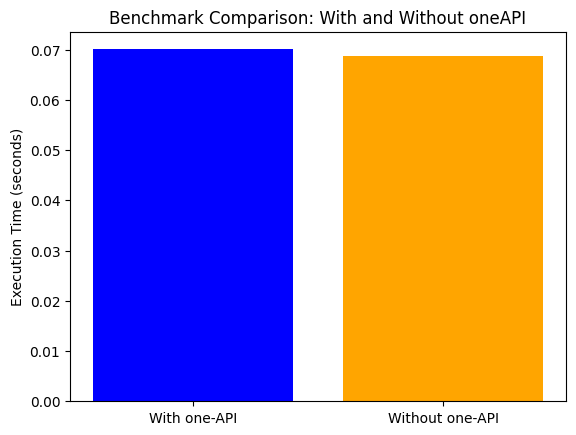

In [101]:
# Print the results
from sklearnex import patch_sklearn
patch_sklearn()
print(f'Benchmark with oneAPI Execution Time: {execution_time_with_oneapi} seconds')
print(f'Benchmark without oneAPI Execution Time: {execution_time_without_oneapi} seconds')
# Plot the results
labels = ['With one-API', 'Without one-API']
execution_times = [execution_time_with_oneapi, execution_time_without_oneapi]

plt.bar(labels, execution_times, color=['blue', 'orange'])
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark Comparison: With and Without oneAPI')
plt.show()